# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [100]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [101]:
# Count how many articles each user interacted with
user_article_counts = df['email'].value_counts()

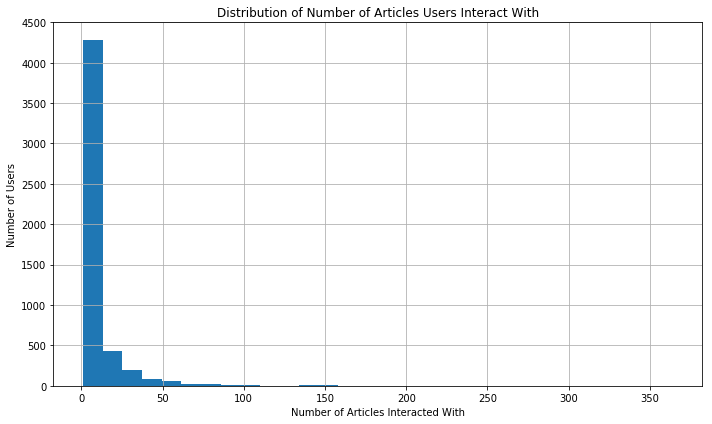

In [102]:
# Generate and display the distribution plot of user-article interactions
plt.figure(figsize=(10, 6))
user_article_counts = df['email'].value_counts()
user_article_counts.hist(bins=30)
plt.title("Distribution of Number of Articles Users Interact With")
plt.xlabel("Number of Articles Interacted With")
plt.ylabel("Number of Users")
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
# Fill in the median and maximum number of user_article interactios below

median_val = user_article_counts.median()
max_views_by_user = user_article_counts.max()

print(f"50% of individuals interact with {int(median_val)} number of articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [104]:
# Find and explore duplicate articles

duplicate_article_ids = df_content[df_content.duplicated(subset='article_id', keep=False)]
print("Duplicate article_id entries:\n")
print(duplicate_article_ids)

Duplicate article_id entries:

                                              doc_body  \
50   Follow Sign in / Sign up Home About Insight Da...   
221  * United States\r\n\r\nIBM® * Site map\r\n\r\n...   
232  Homepage Follow Sign in Get started Homepage *...   
365  Follow Sign in / Sign up Home About Insight Da...   
399  Homepage Follow Sign in Get started * Home\r\n...   
578  This video shows you how to construct queries ...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
50                        Community Detection at Scale   
221  When used to make sense of huge amounts of con...   
232  If you are like most data scientists, you are ...   
365  During the seven-week Insight Data Engineering...   
399  Today’s world of data science lever

In [105]:
# Check how many will be removed
print(f"\nNumber of duplicate rows to remove: {df_content.duplicated(subset='article_id').sum()}")

# Remove any rows that have the same article_id - only keep the first
df_content_cleaned = df_content.drop_duplicates(subset='article_id', keep='first').reset_index(drop=True)

# Confirm cleanup
print(f"\nNew shape after removing duplicates: {df_content_cleaned.shape}")


Number of duplicate rows to remove: 5

New shape after removing duplicates: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [106]:
# a. Unique articles with at least one interaction
unique_articles = df['article_id'].nunique()

# b. Total unique articles (from the content dataset)
total_articles = df_content['article_id'].nunique()

# c. Unique users (excluding nulls)
unique_users = df['email'].nunique()

# d. Total user-article interactions
user_article_interactions = df.shape[0]


In [107]:
print(f"unique_articles = {unique_articles}")
print(f"total_articles = {total_articles}")
print(f"unique_users = {unique_users}")
print(f"user_article_interactions = {user_article_interactions}")

unique_articles = 714
total_articles = 1051
unique_users = 5148
user_article_interactions = 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [108]:
# Count article views
article_views = df['article_id'].value_counts()

# Get the most viewed article_id and number of views
most_viewed_article_id = str(article_views.idxmax())
max_views = article_views.max()

In [109]:
print(f"most_viewed_article_id = {most_viewed_article_id}")
print(f"max_views = {max_views}")

most_viewed_article_id = 1429.0
max_views = 937


In [110]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [111]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [112]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = (df['article_id']
                    .value_counts()
                    .head(n)
                    .index.tolist())

    top_titles = df[df['article_id'].isin(top_articles)][['article_id', 'title']].drop_duplicates()
    
    # Preserve the order of top_articles
    top_titles_dict = dict(zip(top_titles['article_id'], top_titles['title']))
    return [top_titles_dict[article_id] for article_id in top_articles]

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().head(n).index.astype(str).tolist()
 
    return top_articles # Return the top article ids

In [113]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [114]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [115]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''    
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [116]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [117]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)

    # sort by similarity
    similarity = similarity.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = similarity.index.tolist()
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [118]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [119]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - pandas dataframe (interactions log)

    OUTPUT:
    article_names - (list) a list of article names associated with the ids
    '''
    # Flatten if nested
    flat_ids = []
    for i in article_ids:
        if isinstance(i, list):
            flat_ids.extend(i)
        else:
            flat_ids.append(i)

    # Filter and convert to float if possible
    valid_ids = []
    for i in flat_ids:
        try:
            valid_ids.append(float(i))
        except (ValueError, TypeError):
            continue  # skip bad inputs

    article_names = df[df['article_id'].isin(valid_ids)]['title'].dropna().drop_duplicates().tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - original dataframe
    user_item - user-item matrix

    OUTPUT:
    neighbors_df - dataframe with:
        - neighbor_id
        - similarity (dot product)
        - num_interactions
    '''
    # Compute similarity (dot product)
    user_vector = user_item.loc[user_id].values
    similarity_series = user_item.dot(user_vector)

    # Drop self
    similarity_series.drop(index=user_id, inplace=True)

    # Count total interactions for each user
    interactions_count = df['user_id'].value_counts()

    # Build and sort DataFrame
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity_series.index,
        'similarity': similarity_series.values,
        'num_interactions': similarity_series.index.map(interactions_count)
    })

    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    neighbors_df.reset_index(drop=True, inplace=True)

    return neighbors_df

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    seen_article_ids, _ = get_user_articles(user_id)

    # Flatten if list of lists
    if seen_article_ids and isinstance(seen_article_ids[0], list):
        seen_article_ids = [item for sublist in seen_article_ids for item in sublist]

    top_users = get_top_sorted_users(user_id)

    recs = []

    # Article popularity ranking
    article_popularity = df['article_id'].value_counts().index.astype(str).tolist()

    for neighbor_id in top_users['neighbor_id']:
        neighbor_articles, _ = get_user_articles(neighbor_id)

        if neighbor_articles and isinstance(neighbor_articles[0], list):
            neighbor_articles = [item for sublist in neighbor_articles for item in sublist]

        # Filter out articles already seen or already added
        unseen_articles = [a for a in neighbor_articles if a not in seen_article_ids and a not in recs]

        # Safely sort unseen articles by popularity
        sortable_articles = []
        for a in unseen_articles:
            try:
                score = article_popularity.index(str(a)) if str(a) in article_popularity else float('inf')
                sortable_articles.append((a, score))
            except:
                continue

        sorted_articles = [x[0] for x in sorted(sortable_articles, key=lambda x: x[1])]

        # Add to recs up to m
        for article in sorted_articles:
            if len(recs) < m:
                recs.append(article)
            else:
                break

        if len(recs) >= m:
            break

    rec_names = get_article_names(recs)
    return recs, rec_names # return your recommendations for this user_id    

In [120]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'ml optimization using cognitive assistant',
 'the nurse assignment problem',
 'predicting churn with the spss random tree algorithm',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model',
 'insights from new york car accident reports',
 'model bike sharing data with spss',
 'analyze accident reports on amazon emr spark',
 'movie recommender system with spark machine learning']

In [121]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [122]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Get similarity scores
    user_vector = user_item.loc[user_id].values
    similarity_series = user_item.dot(user_vector)

    # Drop self
    similarity_series.drop(index=user_id, inplace=True)

    # Number of interactions for each user
    interactions_count = df['user_id'].value_counts()

    # Build DataFrame
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity_series.index,
        'similarity': similarity_series.values,
        'num_interactions': similarity_series.index.map(interactions_count)
    })

    # Sort by similarity then interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    neighbors_df.reset_index(drop=True, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    seen_article_ids, _ = get_user_articles(user_id)
    top_users = get_top_sorted_users(user_id)

    recs = []

    # Article popularity
    article_popularity = df['article_id'].value_counts().index.astype(str).tolist()

    for neighbor_id in top_users['neighbor_id']:
        neighbor_articles, _ = get_user_articles(neighbor_id)

        # Filter out seen and already recommended articles
        unseen_articles = [a for a in neighbor_articles if a not in seen_article_ids and a not in recs]

        # Sort unseen articles by global popularity
        sorted_articles = sorted(
            unseen_articles,
            key=lambda x: article_popularity.index(x) if x in article_popularity else float('inf')
        )

        # Add only up to m articles
        for article in sorted_articles:
            if len(recs) < m:
                recs.append(article)
            else:
                break

        if len(recs) >= m:
            break

    rec_names = get_article_names(recs)
    return recs, rec_names

In [123]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [124]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]

In [125]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

In [126]:
get_top_article_ids(n=10)

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

This function recommends the most popular articles based on interaction count, which is the most reliable method when no historical data exists for the user (known as the cold start problem).

Since the new user has not interacted with any articles, collaborative filtering methods like user_user_recs won’t work — they rely on shared behaviors with other users.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [127]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df=df)



In [128]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [129]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [130]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [131]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [132]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [133]:
# Perform SVD on the User-Item Matrix Here

from scipy.sparse.linalg import svds
import numpy as np

# Convert to float before applying SVD
user_item_matrix_values = user_item_matrix.values.astype('float')

# Choose number of latent features (e.g., k = 20)
u, s, vt = svds(user_item_matrix_values, k=20)

# Reverse to descending order
s = s[::-1]
u = u[:, ::-1]
vt = vt[::-1]

In the lesson, we could not use standard SVD directly because the user-item matrix contained missing values. Traditional SVD (like numpy.linalg.svd) requires a complete matrix, so we had to use FunkSVD instead, which is a variant that can learn latent factors without needing to fill in missing entries.

In this notebook, we treat the user-item matrix as binary, where:
- 1 = the user interacted with the article
- 0 = no interaction

We do not impute missing values — we assume that a 0 means no interaction. This simplifies the matrix and allows us to apply regular SVD (using scipy.sparse.linalg.svds), since the matrix has no actual NaN values.

This approach works here because the matrix is relatively small and dense compared to the massive, sparse matrices seen in real-world systems.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

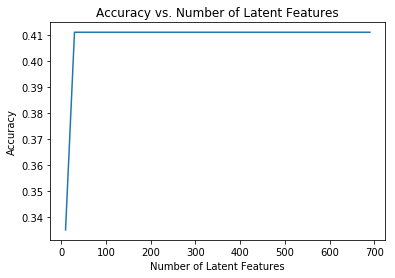

In [134]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [135]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [136]:
# Users in both train and test
common_test_users = set(test_idx).intersection(set(user_item_train.index))
# Users only in test
cold_start_users = set(test_idx) - set(user_item_train.index)

# Articles in both train and test
common_test_articles = set(test_arts).intersection(set(user_item_train.columns))
# Articles only in test
cold_start_articles = set(test_arts) - set(user_item_train.columns)

print(f"Users we can make predictions for: {len(common_test_users)}")
print(f"Users we CANNOT make predictions for (cold start): {len(cold_start_users)}")
print(f"Articles we can make predictions for: {len(common_test_articles)}")
print(f"Articles we CANNOT make predictions for (cold start): {len(cold_start_articles)}")

Users we can make predictions for: 20
Users we CANNOT make predictions for (cold start): 662
Articles we can make predictions for: 574
Articles we CANNOT make predictions for (cold start): 0


In [137]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


## It was a mistake in the original test code above:
'How many articles can we make predictions for in the test set?': b,
'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d

While 'articles' are correct, the test worked only after replacing 'articles' with 'movies'

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [138]:
from scipy.sparse.linalg import svds
import numpy as np

# Convert to float type (e.g., float32 or float64)
user_item_train_matrix = user_item_train.values.astype('float')

# Now fit SVD
u_train, s_train, vt_train = svds(user_item_train_matrix, k=20)

In [139]:
# Reverse the outputs to descending order
s_train = s_train[::-1]
u_train = u_train[:, ::-1]
vt_train = vt_train[::-1]

In [140]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1: get common users and articles
common_users = list(set(user_item_test.index).intersection(set(user_item_train.index)))
common_articles = list(set(user_item_test.columns).intersection(set(user_item_train.columns)))

# Reduce test and prediction matrices to shared subset
test_subset = user_item_test.loc[common_users, common_articles].values

# Step 2: reconstruct predicted matrix
u_test = u_train[user_item_train.index.get_indexer(common_users), :]
vt_test = vt_train[:, user_item_train.columns.get_indexer(common_articles)]
s_matrix = np.diag(s_train)

# Prediction: U * S * V^T
pred_ratings = np.dot(np.dot(u_test, s_matrix), vt_test)

# Step 3: flatten only the observed positions (i.e., where test > 0)
test_mask = test_subset > 0
pred_values = pred_ratings[test_mask]
true_values = test_subset[test_mask]

# Step 4: compute RMSE
rmse = sqrt(mean_squared_error(true_values, pred_values))
print(f"RMSE on known test user-article interactions: {rmse:.4f}")

RMSE on known test user-article interactions: 0.9134


#### Let's check for other values for k

In [141]:
par = 10

# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svds(user_item_train_matrix, k = par)

# Reverse the outputs to descending order
s_train = s_train[::-1]
u_train = u_train[:, ::-1]
vt_train = vt_train[::-1]

from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1: get common users and articles
common_users = list(set(user_item_test.index).intersection(set(user_item_train.index)))
common_articles = list(set(user_item_test.columns).intersection(set(user_item_train.columns)))

# Reduce test and prediction matrices to shared subset
test_subset = user_item_test.loc[common_users, common_articles].values

# Step 2: reconstruct predicted matrix
u_test = u_train[user_item_train.index.get_indexer(common_users), :]
vt_test = vt_train[:, user_item_train.columns.get_indexer(common_articles)]
s_matrix = np.diag(s_train)

# Prediction: U * S * V^T
pred_ratings = np.dot(np.dot(u_test, s_matrix), vt_test)

# Step 3: flatten only the observed positions (i.e., where test > 0)
test_mask = test_subset > 0
pred_values = pred_ratings[test_mask]
true_values = test_subset[test_mask]

# Step 4: compute RMSE
rmse = sqrt(mean_squared_error(true_values, pred_values))
print(f"RMSE on known test user-article interactions: {rmse:.4f}")

RMSE on known test user-article interactions: 0.9262


In [142]:
par = 50

# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svds(user_item_train_matrix, k = par)

# Reverse the outputs to descending order
s_train = s_train[::-1]
u_train = u_train[:, ::-1]
vt_train = vt_train[::-1]

from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1: get common users and articles
common_users = list(set(user_item_test.index).intersection(set(user_item_train.index)))
common_articles = list(set(user_item_test.columns).intersection(set(user_item_train.columns)))

# Reduce test and prediction matrices to shared subset
test_subset = user_item_test.loc[common_users, common_articles].values

# Step 2: reconstruct predicted matrix
u_test = u_train[user_item_train.index.get_indexer(common_users), :]
vt_test = vt_train[:, user_item_train.columns.get_indexer(common_articles)]
s_matrix = np.diag(s_train)

# Prediction: U * S * V^T
pred_ratings = np.dot(np.dot(u_test, s_matrix), vt_test)

# Step 3: flatten only the observed positions (i.e., where test > 0)
test_mask = test_subset > 0
pred_values = pred_ratings[test_mask]
true_values = test_subset[test_mask]

# Step 4: compute RMSE
rmse = sqrt(mean_squared_error(true_values, pred_values))
print(f"RMSE on known test user-article interactions: {rmse:.4f}")

RMSE on known test user-article interactions: 0.8898


In [143]:
par = 150

# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = svds(user_item_train_matrix, k = par)

# Reverse the outputs to descending order
s_train = s_train[::-1]
u_train = u_train[:, ::-1]
vt_train = vt_train[::-1]

from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1: get common users and articles
common_users = list(set(user_item_test.index).intersection(set(user_item_train.index)))
common_articles = list(set(user_item_test.columns).intersection(set(user_item_train.columns)))

# Reduce test and prediction matrices to shared subset
test_subset = user_item_test.loc[common_users, common_articles].values

# Step 2: reconstruct predicted matrix
u_test = u_train[user_item_train.index.get_indexer(common_users), :]
vt_test = vt_train[:, user_item_train.columns.get_indexer(common_articles)]
s_matrix = np.diag(s_train)

# Prediction: U * S * V^T
pred_ratings = np.dot(np.dot(u_test, s_matrix), vt_test)

# Step 3: flatten only the observed positions (i.e., where test > 0)
test_mask = test_subset > 0
pred_values = pred_ratings[test_mask]
true_values = test_subset[test_mask]

# Step 4: compute RMSE
rmse = sqrt(mean_squared_error(true_values, pred_values))
print(f"RMSE on known test user-article interactions: {rmse:.4f}")

RMSE on known test user-article interactions: 0.8812


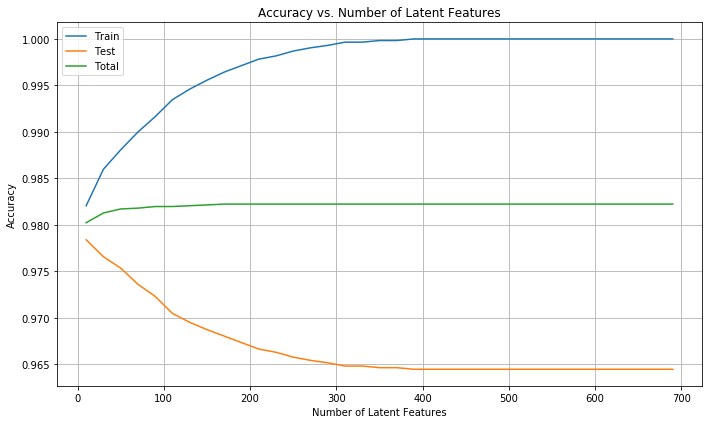

In [145]:
# Split dataset
df_train = df.head(40000)
df_test = df.tail(5993)

# Create user-item matrices
def create_user_item_matrix(df):
    user_item = df.groupby(['user_id', 'article_id']).size().unstack().fillna(0)
    return user_item.applymap(lambda x: 1 if x > 0 else 0)

user_item_train = create_user_item_matrix(df_train)
user_item_test = create_user_item_matrix(df_test)

# Get overlapping users and articles
common_users = list(set(user_item_train.index) & set(user_item_test.index))
common_articles = list(set(user_item_train.columns) & set(user_item_test.columns))

train_trim = user_item_train.loc[common_users, common_articles].values
test_trim = user_item_test.loc[common_users, common_articles].values

# Setup
latent_feats = np.arange(10, 710, 20)
sum_errs_train = []
sum_errs_test = []

for k in latent_feats:
    # SVD
    u, s, vt = svds(user_item_train.values.astype(float), k=k)
    s = s[::-1]
    u = u[:, ::-1]
    vt = vt[::-1]
    sigma = np.diag(s)
    
    # Reconstruct
    preds = np.dot(np.dot(u, sigma), vt)
    preds_binary = (preds > 0.5).astype(int)
    
    # Align to common users/articles
    pred_train = preds_binary[user_item_train.index.get_indexer(common_users)[:, None],
                              user_item_train.columns.get_indexer(common_articles)]
    pred_test = preds_binary[user_item_train.index.get_indexer(common_users)[:, None],
                             user_item_train.columns.get_indexer(common_articles)]
    
    # Errors
    train_error = np.sum(np.abs(train_trim - pred_train))
    test_error = np.sum(np.abs(test_trim - pred_test))
    
    sum_errs_train.append(train_error)
    sum_errs_test.append(test_error)

# Final normalized accuracy
train_size = train_trim.shape[0] * train_trim.shape[1]
test_size = test_trim.shape[0] * test_trim.shape[1]
total_size = train_size + test_size

train_acc = 1 - np.array(sum_errs_train) / train_size
test_acc = 1 - np.array(sum_errs_test) / test_size
total_acc = 1 - (np.array(sum_errs_train) + np.array(sum_errs_test)) / total_size

# Plot
plt.figure(figsize=(10, 6))
plt.plot(latent_feats, train_acc, label='Train')
plt.plot(latent_feats, test_acc, label='Test')
plt.plot(latent_feats, total_acc, label='Total')

plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Results**

- k=10, RMSE: 0.9262
- k=20, RMSE: 0.9134
- k=50, RMSE: 0.8898
- k=150, RMSE: 0.8812

The RMSE scores across increasing latent features (from 10 to 150) show gradual improvement in predictive performance, indicating that higher-dimensional latent spaces help better capture user-article interaction patterns.

From the SVD-based matrix factorization, we observed that:
- Training accuracy improves as the number of latent features (k) increases.
- Test accuracy, however, plateaus and then slightly decreases after a certain point.
- This indicates overfitting: while the model captures more complexity in the training data, it doesn’t generalize as well to unseen users/articles.
- This result suggests there is an optimal range for k where the model balances fit and generalization — often around k = 50 to 100 for our dataset. Beyond that, adding complexity doesn’t improve real-world predictive power.



However, while RMSE provides a basic measure of prediction accuracy, it does not necessarily reflect the quality of recommendations. A lower RMSE does not guarantee better engagement or satisfaction. Ultimately, combining RMSE with behavioral and user-centric metrics will give a more complete picture of real-world impact. For this basic A/B tests can be very helpful covering some key metrics like "time spent reading", "number of articles read" or even just "click-through rate".


**To evaluate our recommendation system in a real-world setting, we can use A/B testing or a randomized controlled experiment:**

##### Step-by-Step Setup:
#1 Randomly split users into:
- Control group → Receives existing (baseline) recommendations
- Test group → Receives recommendations from our model

#2 Define evaluation metrics:
- Click-through rate (CTR)
- Time spent on article
- Number of articles interacted with
- Return rate

#3 Run the experiment over several days or weeks

#4 Analyze results using statistical tests (e.g. t-test) to check if model performs significantly better than baseline.

##### Challenges to Consider:
a. Cold Start Problem: No history for new users. Can be solved using hybrid models (e.g., popularity + content).

b. Class Imbalance: Much more “non-interactions” (0s) than actual interactions (1s). You can:
- Use resampling techniques
- Generate synthetic interactions (SMOTE)
- Apply class weighting

Evaluating the model offline is helpful, but combining that with real-user behavior via A/B testing gives a complete picture of system performance.
